Focus this week:

*   Recurrent dropout, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
*   Stacking recurrent layers, to increase the representational power of the network (at the cost of higher computational loads).
*   Bidirectional recurrent layers, which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues (pt. 2)

The last of these is also a key technique in Language Modelling, Bi-LM.

We'll focus on some Freddie data this time to bring ourselves back to a
more job focused approach:

http://www.freddiemac.com/pmms/pmms_archives.html

The goal will be to use a collection of publicly available mortgage variables to forecast the mortgage rate a few periods out.

In [ ]:
from google.colab import files
mtgdataset = files.upload()

Saving historicalweeklydata.xls to historicalweeklydata.xls


In [ ]:
import pandas as pd
df = pd.read_excel('/content/historicalweeklydata.xls')
df.head()

,Week,US 30yr FRM,30 yr feespts,US 15yr FRM,15 yr feespts,US 51 ARM,51 ARM feespts,51 ARM margin,FRMARM sprd,Unnamed: 9
0,1971-04-02,7.33,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1971-04-09,7.31,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1971-04-16,7.31,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1971-04-23,7.31,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1971-04-30,7.29,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


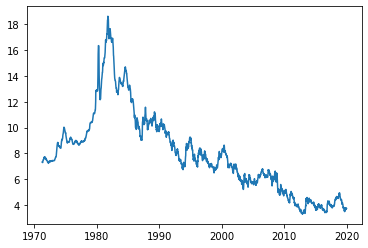

In [ ]:
#Goal will be to predict the 30yr FRM based on historical data, let's see what we have
from matplotlib import pyplot as plt
plt.plot(df['Week'], df['US 30yr FRM'])
plt.show()

What do we notice about this data?

In [ ]:
#Let's figure out the volume of NaN as well in each column
df.isna().sum()

Week                 0
US 30yr FRM          0
30 yr feespts        0
US 15yr FRM       1065
15 yr feespts     1065
US 51 ARM         1762
51 ARM feespts    1762
51 ARM margin     1762
FRMARM sprd       2336
Unnamed: 9        2543
dtype: int64

In [ ]:
#It looks like there were some artifacts mucking up values when I manually cleaned this file
df = df.drop('Unnamed: 9', axis = 1)

In [ ]:
df.shape

(2544, 9)

#Given the shape of this, and the techniques and timescale we're thinking we'll probably throw away the FRMARM spread, leaving us with ~800 datapoints (call it 15 years)

This accomplishes a few convenient things for us:



*   We move away from the massive values seen at the start of the dataset, carrying "too much memory" of history will cause us problems
*   We'll force ourselves to be judicious in how we construct our network.  With so few examples we can't just build super deep networks and hope for the best

But first, we want to start with a baseline to beat.  



In [ ]:
#A reasonable baseline to start with is just to say that next week the rate is the same as this week
df_baseline = df[['Week', 'US 30yr FRM']].set_index('Week')

df_baseline['US 30yr FRM Back'] = df_baseline['US 30yr FRM'].shift()

df_baseline.head()

,US 30yr FRM,US 30yr FRM Back
Week,,
1971-04-02,7.33,NaN
1971-04-09,7.31,7.33
1971-04-16,7.31,7.31
1971-04-23,7.31,7.31
1971-04-30,7.29,7.31


In [ ]:
#Let's limit to the last 800 weeks or so 
df_baseline = df_baseline['2005-01-07':]

In [ ]:
df_baseline.shape

(781, 2)

In [ ]:
import numpy as np
np.mean(np.abs(df_baseline['US 30yr FRM Back'] - df_baseline['US 30yr FRM']))

0.05962868117797698

In [ ]:
np.abs(df_baseline['US 30yr FRM Back'] - df_baseline['US 30yr FRM']).max()

0.5299999999999998

In [ ]:
np.abs(df_baseline['US 30yr FRM Back'] - df_baseline['US 30yr FRM']).min()

0.0

So, around 6 bps.  Note great but not terrible either

In [ ]:
#Let's start by looking at our first baseline using ML, which won't turn out to be great
df = df.set_index('Week')
df = df['2005-01-07':]

df.isna().sum()

US 30yr FRM         0
30 yr feespts       0
US 15yr FRM         0
15 yr feespts       0
US 51 ARM           0
51 ARM feespts      0
51 ARM margin       0
Unnamed: 9        781
dtype: int64

In [ ]:
df = df.drop('FRMARM sprd', axis = 1)

KeyError: ignored

In [ ]:
#Let's split the data into training, validation, and test sets
y = df['US 30yr FRM']
X = df.drop(['US 30yr FRM'], axis = 1)

X_train, X_val, X_test = X.iloc[:500], X.iloc[500:700], X.iloc[700:]
y_train, y_val, y_test = y.iloc[:500], y.iloc[500:700], y.iloc[700:]

In [ ]:
#Data must be normalized
y_mean, y_std = y.mean(), y.std()
X_mean, X_std = X.mean(axis=0), X.std(axis=0)

X_train = (X_train - X_mean)/X_std
X_val = (X_val - X_mean)/X_std
X_test = (X_test - X_mean)/X_std

y_train = (y_train - y_mean)/y_std
y_val = (y_val - y_mean)/y_std
y_test = (y_test - y_mean)/y_std

In [ ]:
#Let's start with just an exercise in curve fitting
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Dense(8, activation='relu', input_shape = [X_train.shape[1]]))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_val, y_val))

Train on 500 samples, validate on 200 samples
Epoch 1/50
500/500 [==============================] - 0s 180us/step - loss: nan - val_loss: nan
Epoch 2/50
500/500 [==============================] - 0s 55us/step - loss: nan - val_loss: nan
Epoch 3/50
500/500 [==============================] - 0s 55us/step - loss: nan - val_loss: nan
Epoch 4/50
500/500 [==============================] - 0s 54us/step - loss: nan - val_loss: nan
Epoch 5/50
500/500 [==============================] - 0s 60us/step - loss: nan - val_loss: nan
Epoch 6/50
500/500 [==============================] - 0s 55us/step - loss: nan - val_loss: nan
Epoch 7/50
500/500 [==============================] - 0s 52us/step - loss: nan - val_loss: nan
Epoch 8/50
500/500 [==============================] - 0s 55us/step - loss: nan - val_loss: nan
Epoch 9/50
500/500 [==============================] - 0s 65us/step - loss: nan - val_loss: nan
Epoch 10/50
500/500 [==============================] - 0s 59us/step - loss: nan - val_loss: nan
Ep

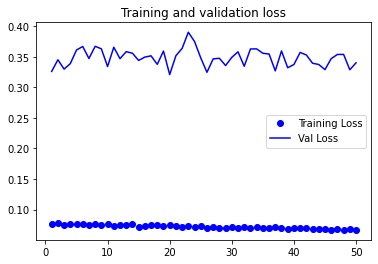

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Val Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Dense(7, input_dim=7, kernel_initializer='normal', activation='relu'))
model.add(layers.Dense(1, kernel_initializer='normal'))


model.compile(optimizer=RMSprop(), loss='mae')

So our first model was pretty bad, performingly significantly worse than the baseline.  Why was this happening?


*   We have relatively little training data
*   We are either over or under complicating the problem

The latter can usually be "easily" investigated in ML by examining what you're getting wrong.  Let's do something similar before moving on.



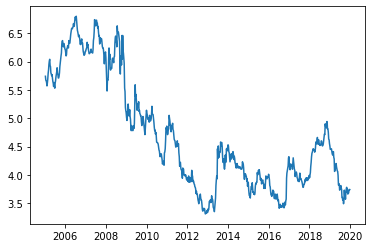

In [ ]:
#Maybe we have found our problem!
plt.plot(df.index, df['US 30yr FRM'])
plt.show()

In [ ]:
X_train

,30 yr feespts,US 15yr FRM,15 yr feespts,US 51 ARM,51 ARM feespts,51 ARM margin
Week,,,,,,
2005-01-13,0.051776,0.957435,0.244433,0.854255,-0.155979,2.660470
2005-01-20,0.894215,0.922350,1.120132,0.854255,0.695905,2.660470
2005-01-27,0.051776,0.913579,0.244433,0.829555,0.695905,2.660470
2005-02-03,0.894215,0.913579,1.120132,0.813088,0.695905,2.660470
2005-02-10,1.73665,0.878495,1.120132,0.804855,1.547788,3.321477
...,...,...,...,...,...,...
2014-07-10,0.894215,-0.752936,0.244433,-0.841815,-1.007862,-1.305571
2014-07-17,0.051776,-0.761707,-0.631266,-0.858282,-1.007862,-0.644564
2014-07-24,0.051776,-0.735394,0.244433,-0.841815,-0.155979,-0.644564


In [ ]:
#Recurrent approach
model_rec = Sequential()

model_rec.add(layers.GRU(32, input_shape=(None, X_train.shape[-1])))
model_rec.add(layers.Dense(1))

model_rec.compile(optimizer=RMSprop(), loss = 'mae')

In [ ]:
X_train2 = np.asarray(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_val2 = np.asarray(X_val).reshape(X_val.shape[0], 1, X_val.shape[1])

In [ ]:
history = model_rec.fit(X_train2, y_train,  epochs = 50, validation_data = (X_val2, y_val))

Train on 500 samples, validate on 200 samples
Epoch 1/50
500/500 [==============================] - 0s 82us/step - loss: 0.0566 - val_loss: 0.1056
Epoch 2/50
500/500 [==============================] - 0s 75us/step - loss: 0.0557 - val_loss: 0.1346
Epoch 3/50
500/500 [==============================] - 0s 70us/step - loss: 0.0567 - val_loss: 0.1104
Epoch 4/50
500/500 [==============================] - 0s 68us/step - loss: 0.0564 - val_loss: 0.1267
Epoch 5/50
500/500 [==============================] - 0s 70us/step - loss: 0.0570 - val_loss: 0.1248
Epoch 6/50
500/500 [==============================] - 0s 71us/step - loss: 0.0571 - val_loss: 0.1220
Epoch 7/50
500/500 [==============================] - 0s 70us/step - loss: 0.0566 - val_loss: 0.1132
Epoch 8/50
500/500 [==============================] - 0s 70us/step - loss: 0.0563 - val_loss: 0.1318
Epoch 9/50
500/500 [==============================] - 0s 70us/step - loss: 0.0563 - val_loss: 0.1240
Epoch 10/50
500/500 [========================

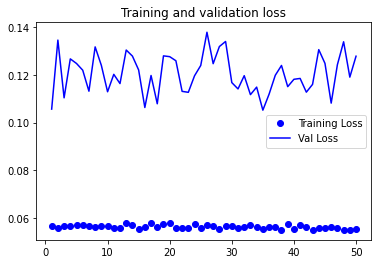

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Val Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()